In [55]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby

## Generating graph

In [56]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

## Bellman-Ford algorithm

In [57]:
from networkx.algorithms import bellman_ford_predecessor_and_distance

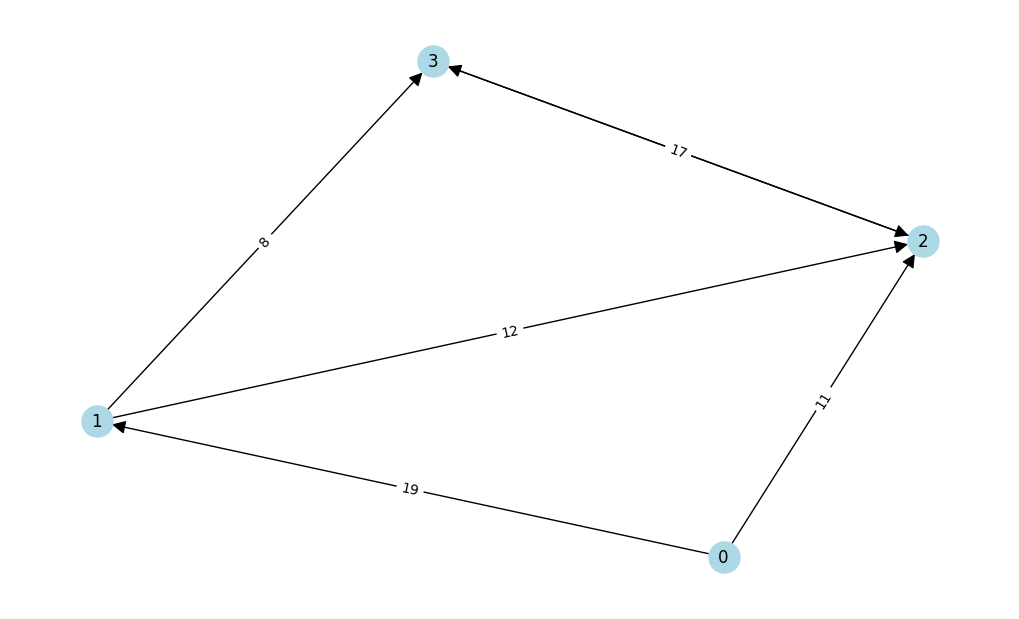

In [58]:
G = gnp_random_connected_graph(4, 0.5, True, True)

In [71]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
def nx_bellman_ford(G, node):
    try:
        _, dist = bellman_ford_predecessor_and_distance(G, node)
        sorted_keys = sorted(dict(dist).keys())
        return {i: dict(dist)[i] for i in sorted_keys}
    except:
        return "Negative cycle detected"
print(nx_bellman_ford(G, 0))

{0: 0, 1: 19, 2: 11, 3: 25}


In [60]:
def bellman_ford(G, node):
    distances = [float('inf')] * G.number_of_nodes()
    distances[list(G.nodes)[node]] = 0
    for _ in range(G.number_of_nodes() - 1):
        for i, k ,w in G.edges(data=True):
            if distances[i] != float('inf') and distances[i] + w['weight'] < distances[k]:
                distances[k] = distances[i] + w['weight']
    for i, k, w in G.edges(data=True):
        if distances[i] != float('inf') and distances[i] + w['weight'] < distances[k]:
            return "Negative cycle detected"
    return distances
print(bellman_ford(G, 0))

[0, 19, 11, 25]


## Floyd-Warshall algorithm

In [61]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

In [62]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
def nx_floyd_warshall(G):
    distances = []
    _, dist = floyd_warshall_predecessor_and_distance(G) 
    for value in dist.values():
        sorted_nodes = sorted(dict(value).keys())
        distances.append(list({i: dict(value)[i] for i in sorted_nodes}.values()))
    for j in range(len(distances)):
        if distances[j][j] < 0:
            return "Negative cycle detected"
    return distances
print(nx_floyd_warshall(G))

[[0, 19, 11, 25], [inf, 0, 12, 8], [inf, inf, 0, 14], [inf, inf, 17, 0]]


In [63]:
def floyd_warshall(G):
    n = G.number_of_nodes()
    diction = {(x[0], x[1]):x[2]['weight'] for x in G.edges(data=True)}
    matrix = [[0 for _ in range(n)] for _ in range(n)]
    for i, line in enumerate(matrix):
        for k in range(len(line)):
            if i == k:
                matrix[i][k] = 0
            elif (i, k) in G.edges():
                matrix[i][k] = diction[(i, k)]
            else:
                matrix[i][k] = float('inf')
    for a in range(n):
        for b in range(n):
            for c in range(n):
                if matrix[b][c] > matrix[b][a] + matrix[a][c]:
                    matrix[b][c] = matrix[b][a] + matrix[a][c]
    for j in range(n):
        if matrix[j][j] < 0:
            return "Negative cycle detected"
    return matrix
print(floyd_warshall(G))

[[0, 19, 11, 25], [inf, 0, 12, 8], [inf, inf, 0, 14], [inf, inf, 17, 0]]


## Testing

### 1. Testing correctness
We need to check whether the algorithms return the same data with the same input.

Let's test them on graphs of different sizes.

In [78]:

def test(name):
    for n in range(1, 7):
        n = 2 ** n
        print(">>> Graph size:", n)
        for j in range(1, 5):
            G = gnp_random_connected_graph(n, 1 / j, True, False)
            if name == 'f':
                nx_result = nx_floyd_warshall(G)
                our_result = floyd_warshall(G)
                assert nx_result == our_result
            if name == 'b':
                for k in range(n):
                    nx_result = nx_bellman_ford(G, k)
                    if isinstance(nx_result, dict):
                        nx_result = list(nx_bellman_ford(G, k).values())
                    our_result = bellman_ford(G, k)
                    if isinstance(our_result, list) and float('inf') in our_result:
                        our_result = [x for x in our_result if x != float('inf')]
                    assert nx_result == our_result


In [79]:
print("Test Bellman-Ford implementation")
test('b')
print("Test Floyd-Warshall implementation")
test('f')

Test Bellman-Ford implementation
>>> Graph size: 2
>>> Graph size: 4
>>> Graph size: 8
>>> Graph size: 16
>>> Graph size: 32
>>> Graph size: 64
Test Floyd-Warshall implementation
>>> Graph size: 2
>>> Graph size: 4
>>> Graph size: 8
>>> Graph size: 16
>>> Graph size: 32
>>> Graph size: 64


### Time tests
Testing time performance of algorithms

In [80]:
import time
def plot_time_size(algorithms: dict[str, callable], max_nodes: int, completeness: float, step: str):

    algorithms_performance = {algorithm: [] for algorithm in algorithms}

    x = list(range(1, max_nodes+step, step))

    for i in x:
        g = gnp_random_connected_graph(i, completeness, True, False)

        for algorithm, algorithm_function in algorithms.items():
            if algorithm_function in [bellman_ford, bellman_ford_predecessor_and_distance]:
                start = time.perf_counter()
                try:
                    algorithm_function(g, 0)
                except:
                    pass
                end = time.perf_counter()
            else:
                start = time.perf_counter()
                try:
                    algorithm_function(g)
                except:
                    pass
                end = time.perf_counter()
            algorithms_performance[algorithm].append(end-start)

    for algorithm, performance in algorithms_performance.items():
        plt.plot(x, performance, label=algorithm)
    plt.legend()

    plt.show()


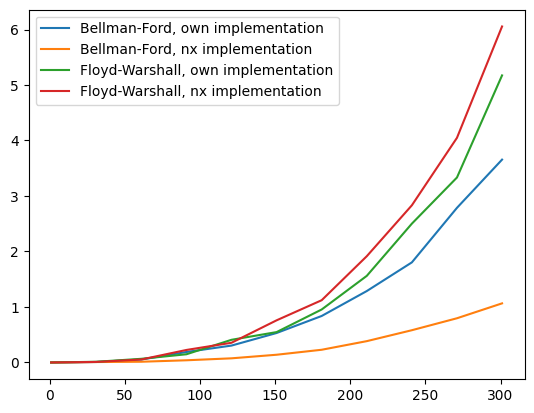

In [84]:
algorithms = {
    'Bellman-Ford, own implementation': bellman_ford,
    "Bellman-Ford, nx implementation": bellman_ford_predecessor_and_distance,
    "Floyd-Warshall, own implementation": floyd_warshall,
    "Floyd-Warshall, nx implementation": floyd_warshall_predecessor_and_distance
}

plot_time_size(algorithms, 300, 0.5, 30)